# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В рамках задания будут выполнены следующие действия:
 
Загрузка и предобработка данных.

Сравнение моделей с использованием различных наборов гиперпараметров.

Выбор лучшей модели по результатам метрики RMSE и времени обучения.

## Подготовка данных

In [1]:
#Загрузим необходимые библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from time import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
#Загрузим данные
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    print('Ошибка. Проверьте правильность пути к данным')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df.describe(include=[object])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [6]:
#посмотрим на процент пропусков в данных
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.580000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.560000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.280000


In [7]:
df.duplicated().value_counts()

False    354365
True          4
dtype: int64

In [8]:
#Удалим дубликаты
df.drop_duplicates(inplace=True)

In [9]:
#Заполним пропуски в данных
df["VehicleType"] = df["VehicleType"].fillna('unknown')
df["Gearbox"] = df["Gearbox"].fillna('unknown')
df["Model"] = df["Model"].fillna('unknown')
df["FuelType"] = df["FuelType"].fillna('unknown')

df["NotRepaired"] = df["NotRepaired"].fillna("no")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  NotRepaired        354365 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [10]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Я долго думал как заполнить пропуски. Удалять данные не хотелось, в некоторых столбцах пропусков очень много(около 20 процентов). Заполнять средними или соседними значениями пропуски в категориальных данных, я тоже посчитал неправильным. Поэтому решил заменить пропуски в столбцах значением 'unknown'. Ведь мы действительно не знаем, что за значения там могут быть. Об этом известно только владельцам автомобилей.

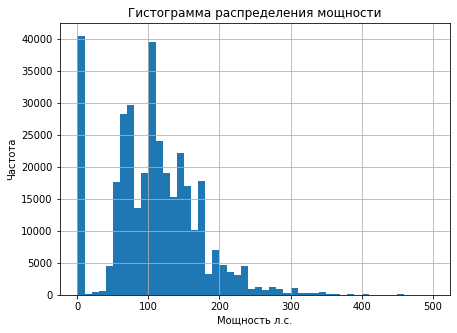

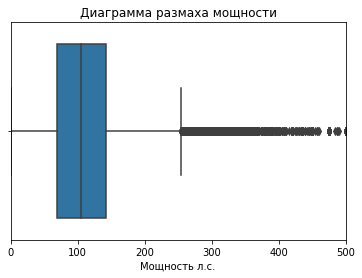

In [11]:
# Строим гистаграмму  распределения мощности
df.plot(y = 'Power', kind = 'hist', bins = 50, grid=True, figsize = (7,5), range = (0,500), legend=None)
plt.title('Гистограмма распределения мощности')
plt.xlabel('Мощность л.с.')
plt.ylabel('Частота')
plt.show()
sns.boxplot(df['Power'])
plt.title('Диаграмма размаха мощности')
plt.xlabel('Мощность л.с.')
plt.xlim(0, 500)
plt.show()

In [12]:
df['Power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: Power, Length: 712, dtype: int64

In [13]:
medians  = df.groupby('Model')['Power'].median().to_dict()
def fill_with_median (row):
    if row['Power'] == 0:
        return medians [row['Model']]
    return row['Power']
df['Power'] = df.apply(lambda row: fill_with_median(row), axis = 1)

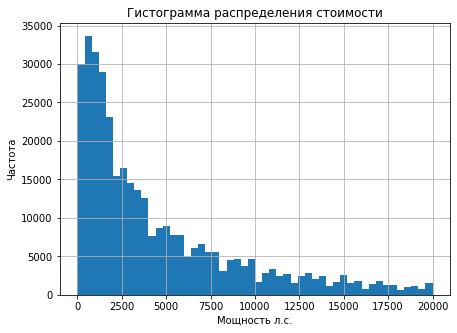

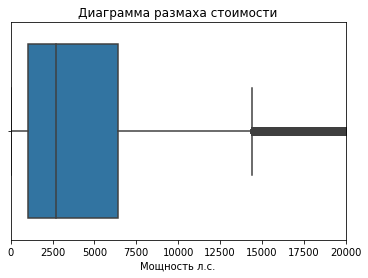

In [14]:
# Строим гистаграмму стоимости автомобилей
df.plot(y = 'Price', kind = 'hist', bins = 50, grid=True, figsize = (7,5), range = (0,20000), legend=None)
plt.title('Гистограмма распределения стоимости')
plt.xlabel('Мощность л.с.')
plt.ylabel('Частота')
plt.show()
sns.boxplot(df['Price'])
plt.title('Диаграмма размаха стоимости')
plt.xlabel('Мощность л.с.')
plt.xlim(0, 20000)
plt.show()

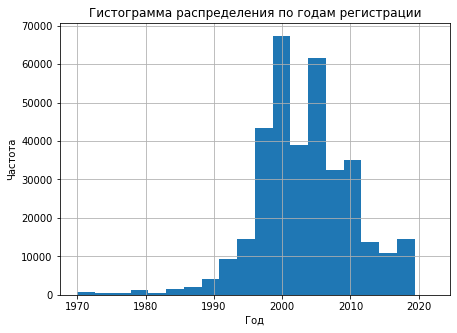

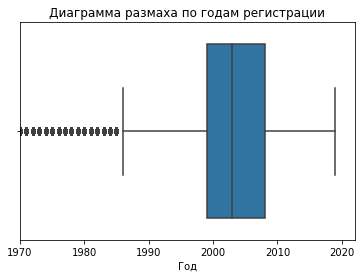

In [15]:
# Строим гистаграмму распределения по годам регистрации автомобилей
df.plot(y = 'RegistrationYear', kind = 'hist', bins = 20, grid=True, figsize = (7,5), range = (1970,2022), legend=None)
plt.title('Гистограмма распределения по годам регистрации')
plt.xlabel('Год')
plt.ylabel('Частота')
plt.show()
sns.boxplot(df['RegistrationYear'])
plt.title('Диаграмма размаха по годам регистрации')
plt.xlabel('Год')
plt.xlim(1970, 2022)
plt.show()

In [16]:
df = df.query('1900 <= RegistrationYear <= 2022')

In [17]:
def make_price_plot(feature, title):
    mean_price = df[[feature, 'Price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(10,5))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='Price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена', size=12)
    plt.title(title, size=12, y=1.02)
    plt.show()

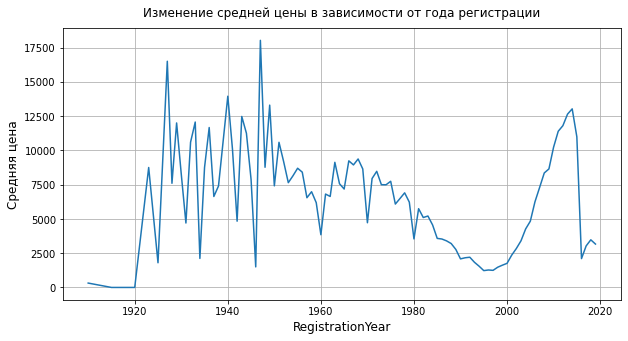

In [18]:
make_price_plot('RegistrationYear', 'Изменение средней цены в зависимости от года регистрации')

In [19]:
def car_cat(row):
    if 1900 <= row['RegistrationYear'] <= 1970:
        return 'retro'
    if 1970 < row['RegistrationYear'] <= 2000:
        return 'old'
    if row['RegistrationYear'] > 2000:
        return 'new'

In [20]:
df['CarsCat'] = df.apply(car_cat, axis=1)

In [21]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,CarsCat
0,2016-03-24 11:52:17,480,unknown,1993,manual,95.0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,old
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,new
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,new
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,new
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,new


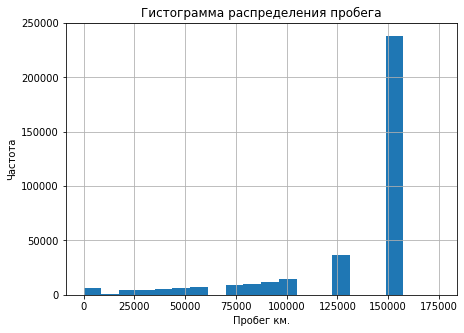

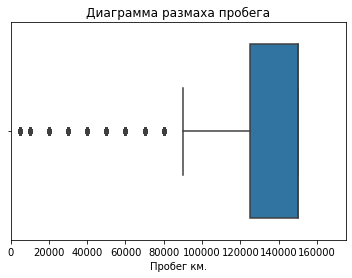

In [22]:
# Строим гистаграмму распределения пробега
df.plot(y = 'Kilometer', kind = 'hist', bins = 20, grid=True, figsize = (7,5), range = (0,175000), legend=None)
plt.title('Гистограмма распределения пробега')
plt.xlabel('Пробег км.')
plt.ylabel('Частота')
plt.show()
sns.boxplot(df['Kilometer'])
plt.title('Диаграмма размаха пробега')
plt.xlabel('Пробег км.')
plt.xlim(0, 175000)
plt.show()

Глядя на гистограммы распределения и диаграммы размаха я решил удалить выбросы. Для этого сделаем срез данных со следующими значениями:

In [23]:
df_new = df.copy().query('100 <= Price')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340936 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        340936 non-null  object 
 1   Price              340936 non-null  int64  
 2   VehicleType        340936 non-null  object 
 3   RegistrationYear   340936 non-null  int64  
 4   Gearbox            340936 non-null  object 
 5   Power              340936 non-null  float64
 6   Model              340936 non-null  object 
 7   Kilometer          340936 non-null  int64  
 8   RegistrationMonth  340936 non-null  int64  
 9   FuelType           340936 non-null  object 
 10  Brand              340936 non-null  object 
 11  NotRepaired        340936 non-null  object 
 12  DateCreated        340936 non-null  object 
 13  NumberOfPictures   340936 non-null  int64  
 14  PostalCode         340936 non-null  int64  
 15  LastSeen           340936 non-null  object 
 16  Ca

**Вывод:** Данные подготовлены для обучения моделей:
Удалены дубликаты.
Заполнены пропуски в категориальный данных.
Данные очищены от выбросов. 

## Обучение моделей

Обучим на наших данных несколько моделей, чтобы сравнить скорость и точность предсказаний.

In [24]:
# Удалим ненужные для обучения моделей столбцы
df_new = df_new.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [25]:
#определим признаки
features = df_new.drop('Price', axis=1)
target = df_new['Price']

In [26]:
#Применим прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType', 'FuelType', 'Brand', 'Model', 'Gearbox', 'NotRepaired', 'CarsCat']
cat_features = features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index).astype(np.int)
ordinal_features = features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

In [27]:
df_new.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,CarsCat
0,480,unknown,1993,manual,95.0,golf,150000,0,petrol,volkswagen,no,old
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,new
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no,new
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,new
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,new


In [28]:
#OHE кодирование
ohe_features = pd.get_dummies(features, drop_first=True)

In [29]:
#Разделим данные на тренировочную и тестовую выборки.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]

ohe_features_train = ohe_features.loc[features_train.index, :]
ohe_features_test = ohe_features.loc[features_test.index, :]

Обучим модель LinearRegression с кросс валидацией на тренировочной выборке.

In [30]:
%%time
regressor = LinearRegression()
print('# Идет определение RMSE')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE для LinearRegression =', cv_RMSE_LR)

# Идет определение RMSE

RMSE для LinearRegression = 2750.6679296797706
CPU times: user 1min 41s, sys: 32.5 s, total: 2min 13s
Wall time: 2min 14s


Обучим модель CatBoostRegressor на тренировочной выборке. Определим лучшие значения гиперпараметров для этой модели.

In [35]:
%%time
regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

print('# Идет подбор гиперпараметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train, cat_features = ['VehicleType', 'FuelType', 'Brand', 'Model', 'Gearbox', 'NotRepaired', 'CarsCat'])
print('Лучшие гиперпараметры:')
print()
print(clf.best_params_)
print()
print('Значения RMSE для разных гиперпараметров:')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Идет подбор гиперпараметров



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 4235.6496649	total: 61.4ms	remaining: 6.08s
10:	learn: 2725.3367642	total: 636ms	remaining: 5.14s
20:	learn: 2286.5624007	total: 1.17s	remaining: 4.4s
30:	learn: 2120.0904967	total: 1.7s	remaining: 3.78s
40:	learn: 2034.3731790	total: 2.21s	remaining: 3.18s
50:	learn: 1981.1160181	total: 2.71s	remaining: 2.6s
60:	learn: 1940.1350881	total: 3.2s	remaining: 2.05s
70:	learn: 1910.0951890	total: 3.72s	remaining: 1.52s
80:	learn: 1889.8815663	total: 4.22s	remaining: 989ms
90:	learn: 1873.8292952	total: 4.71s	remaining: 466ms
99:	learn: 1861.7538773	total: 5.17s	remaining: 0us
0:	learn: 4240.7138703	total: 58.4ms	remaining: 5.78s
10:	learn: 2737.5495336	total: 619ms	remaining: 5s
20:	learn: 2291.5944981	total: 1.18s	remaining: 4.45s
30:	learn: 2122.2122637	total: 1.7s	remaining: 3.79s
40:	learn: 2035.8209154	total: 2.2s	remaining: 3.17s
50:	learn: 1980.7181640	total: 2.68s	remaining: 2.58s
60:	learn: 1940.3161884	total: 3.19s	remaining: 2.04s
70:	learn: 1911.3813915	total: 3.7s	rem

KeyboardInterrupt: 

Обучим модель LGBMRegressor на тренировочной выборке. Определим лучшие значения гиперпараметров для этой модели.

In [37]:
%%time
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

print('# Идет подбор гиперпараметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train, categorical_feature = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'CarsCat'])
print('Лучшие гиперпараметры:')
print()
print(clf.best_params_)
print()
print('Значения RMSE для разных гиперпараметров:')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Идет подбор гиперпараметров

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771863
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.227185
[LightGBM] [Debug] init for col-wise cost 0.089894 seconds, init for row-wise cost 0.102097 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 204561, number of used features: 11
[LightGBM] [Info] Start training from score 4585.907367
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 an

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 200 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 18
Trained a tree with leaves = 200 and depth = 22


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 200 and depth = 18
Trained a tree with leaves = 200 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 29
[LightGBM] [Debug] Trained a tree

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 200 and depth = 16


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 200 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 18
[LightGBM] [De

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 200 and depth = 20


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fb1b529d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 200 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 17
[LightGBM] [De

**Вывод:** Лучшую точноть на тренировочной выборке показывает модель  LGBMRegressor с параметрами 'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345.  Но подбор лучших гиперпараметров для этой модели занимает больше всего времени. Причем это время варьируется в очень широком диапазоне от 7 до 30 минут.

## Анализ моделей

Проверим точность и скорость работы моделей с лучшими параметрами на тестовой выборке.

 Модель LinearRegression

In [38]:
model = LinearRegression()
start_model_LR = time()
model.fit(ohe_features_train, target_train)
end_model_LR = time()
start_predict_LR = time()
target_predict = model.predict(ohe_features_test)
end_predict_LR = time()
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE_LR', final_RMSE_LR)
print('Время обучения модели: {:.2f}'.format(end_model_LR - start_model_LR))
print('Время предсказания: {:.2f}'.format(end_predict_LR - start_predict_LR))

RMSE_LR 2755.8817858860675
Время обучения модели: 30.43
Время предсказания: 0.20


 Модель CatBoostRegressor

In [39]:
model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=12345, 
                          verbose=False)
start_model_CBR = time()
model.fit(ordinal_features_train, target_train, cat_features = ['VehicleType', 'FuelType', 'Brand', 'Model', 'Gearbox', 'NotRepaired', 'CarsCat'])
end_model_CBR = time()
start_predict_CBR = time()
target_predict = model.predict(ordinal_features_test)
end_predict_CBR = time()
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE_CBR', final_RMSE_CBR)
print('Время обучения модели: {:.2f}'.format(end_model_CBR - start_model_CBR))
print('Время предсказания: {:.2f}'.format(end_predict_CBR - start_predict_CBR))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

RMSE_CBR 1629.2206098041659
Время обучения модели: 612.90
Время предсказания: 1.23


 Модель LGBMRegressor

In [40]:
model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
start_model_LGBMR = time()
model.fit(ordinal_features_train, target_train, categorical_feature = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'CarsCat'])
end_model_LGBMR = time()
start_predict_LGBMR = time()
target_predict = model.predict(ordinal_features_test)
end_predict_LGBMR = time()
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE_LGBMR', final_RMSE_LGBMR)
print('Время обучения модели: {:.2f}'.format(end_model_LGBMR - start_model_LGBMR))
print('Время предсказания: {:.2f}'.format(end_predict_LGBMR - start_predict_LGBMR))

RMSE_LGBMR 1585.9087284381728
Время обучения модели: 18.67
Время предсказания: 2.60


Соберем результаты работы моделей в общую таблицу.

In [41]:
results = {
    'Model' : ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor'],
    'RMSE' :pd.Series([final_RMSE_LR, 1, final_RMSE_LGBMR]),
    'Время обучения, сек': pd.Series([(end_model_LR-start_model_LR), (end_model_CBR-start_model_CBR), (end_model_LGBMR-start_model_LGBMR)]),
    'Время предсказания, сек': pd.Series([(end_predict_LR-start_predict_LR), (end_predict_CBR-start_predict_CBR), (end_predict_LGBMR-start_predict_LGBMR)])
    }
display(pd.DataFrame(results))

,Model,RMSE,"Время обучения, сек","Время предсказания, сек"
0,LinearRegression,2755.881786,30.433277,0.199016
1,CatBoostRegressor,1.000000,612.900905,1.230298
2,LGBMRegressor,1585.908728,18.672877,2.600201


**Вывод:** CatBoostRegressor показал лучшие значение PMSE на тестовой выборке, но затратил на это больше всего времени. LGBMRegressor совсем немного проигрывает в точности, но работает гораздо быстрее. Простая модель Линейной регрессии очень сильно проигрывает двум другим в точности.